# E-GraphSAGE

In [1]:
from dgl import from_networkx
import sklearn
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import numpy as np
from sklearn.metrics import confusion_matrix

import os
from sklearn.utils import shuffle

from dgl.data.utils import save_graphs

#constante
size_embedding = 152
nb_batch = 5

#Data
nbclasses =  2

# Accuracy --------------------------------------------------------------------
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()
# -----------------------------------------------------------------------------

# ------------------------------------------ Model Architecture -----------------------------------------------------------------

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        x = th.cat([edges.src['h'], edges.data['h']], 2)
        y = self.W_msg(x)
        return {'m': y}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Line 4 of algorithm 1 : update all because we are using a full neighborhood sampling and not a k-hop neigh sampling
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Line 5 of algorithm 1
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, size_embedding, activation))
        self.layers.append(SAGELayer(size_embedding, edim, size_embedding, activation)) ##
        self.layers.append(SAGELayer(size_embedding, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
            # Save edge_embeddings
            # nf = 'edge_embeddings'+str(i)+'.txt'
            # sourceFile = open(nf, 'w')
            # print(nfeats, file = sourceFile)
        return nfeats.sum(1)
        # Return a list of node features [[node1_feature1, node1_feature2, ...], [node2_feature1, node2_feature2, ...], ...]
    
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        v = th.cat([h_u, h_v], 1)
        # if(pr == True):
            # sourceFile = open(filename, 'w')
            # if pr:
                # print(v, file = sourceFile)
            # sourceFile.close()
        score = self.W(v)
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            # Update the features of the specified edges by the provided function
            # DGLGraph.apply_edges(func, edges='__ALL__', etype=None, inplace=False)
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, nbclasses)
    def forward(self, g, nfeats, efeats, eweight = None):
        if eweight != None:
            # apply eweight on the graph
            efe = []
            for i, x in enumerate(eweight):
                efe.append(list(th.Tensor.cpu(g.edata['h'][i][0]).detach().numpy() * th.Tensor.cpu(x).detach().numpy()))

            efe = th.FloatTensor(efe).cuda()
            efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
            g.edata['h'] = efe = efe

        h = self.gnn(g, nfeats, efeats)
        # h = list of node features [[node1_feature1, node1_feature2, ...], [node2_feature1, node2_feature2, ...], ...]
        return self.pred(g, h)

# -------------------------------------------------------------------------------------------------------------------------------

## Graph + Ablation

In [27]:
# # --------------------------------------------------- MAIN -----------------------------------------------------------

import copy


# Model *******************************************************************************************
# G1.ndata['h'].shape[2] = sizeh = 76 dans ANIDS
# model1 = Model(G1.ndata['h'].shape[2], size_embedding, G1.ndata['h'].shape[2], F.relu, 0.2).cuda()
model1 = Model(76, size_embedding, 76, F.relu, 0.2).cuda()
opt = th.optim.Adam(model1.parameters())

model1_ab = Model(76, size_embedding, 76, F.relu, 0.2).cuda()
opt_ab = th.optim.Adam(model1_ab.parameters())


# Classes
clss = ['BENIGN', 'Brute Force', 'XSS', 'Sql Injection', 'Heartbleed', 'DoS Hulk', 'DDoS', 'PortScan', 'FTP-Patator', 'Bot', 'DoS slowloris', 'DoS GoldenEye', 'DoS Slowhttptest', 'SSH-Patator', 'Infiltration']
# Classes mpping
clss_mpping = {}
cpt = 0
for x in clss:
    clss_mpping[x] = cpt
    cpt += 1
print(clss_mpping)



path, dirs, files = next(os.walk("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/input/Dataset/GlobalDataset/Splitted/"))
file_count = len(files)


for nb_files in range(file_count):
    data1 = pd.read_csv(f'{path}{files[nb_files]}', encoding="ISO-8859–1", dtype = str)

    print(f'{files[nb_files]} ++++++++++++++++++++++++++++++++++++++++++++++')
    print("nb total instances in the file : ", len(data1.values))

    print("++++++++++++++++++++++++++++ Train ++++++++++++++++++++++++++++++++")
    
    # Delete two columns (U and V in the excel)
    cols = list(set(list(data1.columns )) - set(list(['Flow Bytes/s',' Flow Packets/s'])) )
    data1 = data1[cols]

    # Mise en forme des noeuds
    data1[' Source IP'] = data1[' Source IP'].apply(str)
    data1[' Source Port'] = data1[' Source Port'].apply(str)
    data1[' Destination IP'] = data1[' Destination IP'].apply(str)
    data1[' Destination Port'] = data1[' Destination Port'].apply(str)
    data1[' Source IP'] = data1[' Source IP'] + ':' + data1[' Source Port']
    data1[' Destination IP'] = data1[' Destination IP'] + ':' + data1[' Destination Port']

    data1.drop(columns=['Flow ID',' Source Port',' Destination Port',' Timestamp'], inplace=True)
    
    data1['DetailedLabel'] = data1[' Label']
    data1['DetailedLabel'] = data1['DetailedLabel'].apply(str)
    # Classes mpping for the DetailedLabel
    data1 = data1.replace({'DetailedLabel': clss_mpping})

    # -------------------- ????????????????????????????????????????? --------------------
    # simply do : nom = list(data1[' Label'].unique())
    nom = []
    nom = nom + [data1[' Label'].unique()[0]]
    for i in range(1, len(data1[' Label'].unique())):
        nom = nom + [data1[' Label'].unique()[i]]
    
    nom.insert(0, nom.pop(nom.index('BENIGN')))

    # Naming the two classes BENIGN {0} / Any Intrusion {1}
    data1[' Label'].replace(nom[0], 0,inplace = True)
    for i in range(1,len(data1[' Label'].unique())):
        data1[' Label'].replace(nom[i], 1,inplace = True)
    
    ##################### LABELS FREQ #######################################
    print()
    print("labels freq after changing labels to binary")
    counts = list(data1[' Label'].value_counts().to_dict().items())
    for j, x in enumerate(counts):
        x = list(x)
        x[1] = x[1] / len(data1)
        counts[j] = x
    print({f'{files[nb_files]}' : counts})
    ##############################################################################

    data1.rename(columns={" Label": "label"},inplace = True)
    label1 = data1.label
    data1.drop(columns=['label'],inplace = True)

    # ******** At this step data1 contains only the data without label column
    # ******** The label column is stored in the label variale 

    # split train and test
    data1 =  pd.concat([data1, label1], axis=1) # ??????? WHY ?
        

    # Split
    X1_train, X1_test, y1_train, y1_test = train_test_split(data1, label1, test_size=0.3, random_state=123, stratify= label1)

    
    # Create mini batches on the Train set
    X1_train = shuffle(X1_train)
    a = b = mean_macro_f1 = 0
    for batch in range(1, nb_batch + 1):
        print(f"+++++++++++++++++ Batch {batch} ++++++++++++++++")
        a = b
        b = int(len(X1_train) / nb_batch) * batch
        if batch == nb_batch :
            b = len(X1_train)
        # The batch :
        X1_train_batched = X1_train.iloc[a:b]
        # y1_train_batched = y1_train.iloc[a:b]
        y1_train_batched = X1_train_batched['label']        
        
        print("nb Train instances : ", len(X1_train_batched.values))

        # for non numerical attributes (categorical data)
        # Since we have a binary classification, the category values willl be replaced with the posterior probability (p(target = Ti | category = Cj))
        # TargetEncoding is also called MeanEncoding, cuz it simply replace each value with (target_i_count_on_category_j) / (total_occurences_of_category_j)
        encoder1 = ce.TargetEncoder(cols=[' Protocol',  'Fwd PSH Flags', ' Fwd URG Flags', ' Bwd PSH Flags', ' Bwd URG Flags'])
        encoder1.fit(X1_train_batched, y1_train_batched)
        X1_train_batched = encoder1.transform(X1_train_batched)

        # scaler (normalization)
        scaler1 = StandardScaler()

        # Manipulate flow content (all columns except : label, Source IP & Destination IP)
        cols_to_norm1 = list(set(list(X1_train_batched.iloc[:, :].columns )) - set(list(['label', ' Source IP', ' Destination IP', 'DetailedLabel'])) )
        X1_train_batched[cols_to_norm1] = scaler1.fit_transform(X1_train_batched[cols_to_norm1])

        ## Create the h attribute that will contain the content of our flows
        X1_train_batched['h'] = X1_train_batched[ cols_to_norm1 ].values.tolist()
        # size of the list containig the content of our flows
        sizeh = len(cols_to_norm1)


        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # Before training the data :
        # We need to delete all the attributes (cols_to_norm1) to have the {Source IP, Destination IP, label, h} representation
        X1_train_batched.drop(columns = cols_to_norm1, inplace = True)
        
        # Edge index
        X1_train_batched['Edge_indx'] = list(range(len(X1_train_batched.values)))

        # Then we need to Swap {label, h} Columns to have the {Source IP, Destination IP, h, label} representation
        columns_titles = [' Source IP', ' Destination IP', 'h', 'label', 'Edge_indx', 'DetailedLabel']
        X1_train_batched = X1_train_batched.reindex(columns=columns_titles)
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

        # ------------------------------------------- Creating the Graph Representation -------------------------------------------------------------
        # Create our Multigraph
        G1 = nx.from_pandas_edgelist(X1_train_batched, " Source IP", " Destination IP", ['h','label', 'Edge_indx', 'DetailedLabel'], create_using=nx.MultiDiGraph())
        print("initial nx multigraph G1 : ", G1)

        G1 = from_networkx(G1, edge_attrs=['h','label', 'Edge_indx', 'DetailedLabel'] )
        print("G1.edata['h'] after converting it to a dgl graph : ", len(G1.edata['h']))

        # nodes data // G1.edata['h'].shape[1] : sizeh = number of attributes in a flow
        G1.ndata['h'] = th.ones(G1.num_nodes(), G1.edata['h'].shape[1])
        # edges data // we create a tensor bool array that will represent the train mask
        G1.edata['train_mask'] = th.ones(len(G1.edata['h']), dtype=th.bool)

        # Reshape both tensor lists to a single value in each element for both axis
        G1.ndata['h'] = th.reshape(G1.ndata['h'], (G1.ndata['h'].shape[0], 1, G1.ndata['h'].shape[1]))
        G1.edata['h'] = th.reshape(G1.edata['h'], (G1.edata['h'].shape[0], 1, G1.edata['h'].shape[1]))
        print("G1.edata['h'] after reshape : ", len(G1.edata['h']))
        # ------------------------------------------- --------------------------------- -------------------------------------------------------------

        

        
        # Ablation *************************************************************************
        X1_train_ab = copy.deepcopy(X1_train_batched)

        # print("data IP Addr before changing them : ")
        # print(X1_train_ab[[' Source IP', ' Destination IP']])

        X1_train_ab = X1_train_ab.drop(' Source IP', axis=1)
        X1_train_ab = X1_train_ab.drop(' Destination IP', axis=1)
        
        X1_train_ab[' Source IP'] = list(range(len(X1_train_ab.values)))
        X1_train_ab[' Destination IP'] = list(range(len(X1_train_ab.values), 2 * len(X1_train_ab.values)))

        print()
        # print("data IP Addr after changing them : ")
        # print(X1_train_ab[[' Source IP', ' Destination IP']])
        
        # ------------------------------------------- Creating the Graph Representation -------------------------------------------------------------
        # Create our Ablation Multigraph
        G1_ab = nx.from_pandas_edgelist(X1_train_ab, " Source IP", " Destination IP", ['h','label', 'Edge_indx', 'DetailedLabel'], create_using=nx.MultiDiGraph())
        print("initial nx multigraph G1_ab : ", G1_ab)

        G1_ab = from_networkx(G1_ab, edge_attrs=['h','label', 'Edge_indx', 'DetailedLabel'] )
        print("G1_ab.edata['h'] after converting it to a dgl graph : ", len(G1_ab.edata['h']))

        # nodes data // G1_ab.edata['h'].shape[1] : sizeh = number of attributes in a flow
        G1_ab.ndata['h'] = th.ones(G1_ab.num_nodes(), G1_ab.edata['h'].shape[1])
        # edges data // we create a tensor bool array that will represent the train mask
        G1_ab.edata['train_mask'] = th.ones(len(G1_ab.edata['h']), dtype=th.bool)

        # Reshape both tensor lists to a single value in each element for both axis
        G1_ab.ndata['h'] = th.reshape(G1_ab.ndata['h'], (G1_ab.ndata['h'].shape[0], 1, G1_ab.ndata['h'].shape[1]))
        G1_ab.edata['h'] = th.reshape(G1_ab.edata['h'], (G1_ab.edata['h'].shape[0], 1, G1_ab.edata['h'].shape[1]))
        print("G1_ab.edata['h'] after reshape : ", len(G1_ab.edata['h']))
        # ------------------------------------------- --------------------------------- -------------------------------------------------------------
        
        # ***********************************************************************************
        
        
        # ------------------------------------------- Model -----------------------------------------------------------------------------------------
        ## use of model
        from sklearn.utils import class_weight
        class_weights1 = class_weight.compute_class_weight(class_weight = 'balanced',
                                                        classes = np.unique(G1.edata['label'].cpu().numpy()),
                                                        y = G1.edata['label'].cpu().numpy())
        class_weights1 = th.FloatTensor(class_weights1).cuda()
        criterion1 = nn.CrossEntropyLoss(weight = class_weights1)
        G1 = G1.to('cuda:0')

        node_features1 = G1.ndata['h']
        edge_features1 = G1.edata['h']

        edge_label1 = G1.edata['label']
        train_mask1 = G1.edata['train_mask']


        # to print
        pr = True
        # True if you want to print the embedding vectors
        # the name of the file where the vectors are printed
        filename = './models/M1_weights.txt'
        
        print("\\\\\\\\\\\\\\\\ NORMAL \\\\\\\\\\\\\\\\\\")

        for epoch in range(1, 1000):
            pred = model1(G1, node_features1, edge_features1).cuda()
            loss = criterion1(pred[train_mask1], edge_label1[train_mask1])
            opt.zero_grad()
            loss.backward()
            opt.step()
            if epoch % 100 == 0:
                print('Training acc:', compute_accuracy(pred[train_mask1], edge_label1[train_mask1]), loss)

        pred1 = model1(G1, node_features1, edge_features1).cuda()
        pred1 = pred1.argmax(1)
        pred1 = th.Tensor.cpu(pred1).detach().numpy()
        edge_label1 = th.Tensor.cpu(edge_label1).detach().numpy()

        print('Train metrics :')
        print("Accuracy : ", sklearn.metrics.accuracy_score(edge_label1, pred1))
        print("Precision : ", sklearn.metrics.precision_score(edge_label1, pred1, labels = [0,1]))
        print("Recall : ", sklearn.metrics.recall_score(edge_label1, pred1, labels = [0,1]))
        print("f1_score : ", sklearn.metrics.f1_score(edge_label1, pred1, labels=[0,1]))
        
        

        
        # ------------------------------------------- AB Model -----------------------------------------------------------------------------------------
        ## use of model
        from sklearn.utils import class_weight
        class_weights1_ab = class_weight.compute_class_weight(class_weight = 'balanced',
                                                        classes = np.unique(G1_ab.edata['label'].cpu().numpy()),
                                                        y = G1_ab.edata['label'].cpu().numpy())
        class_weights1_ab = th.FloatTensor(class_weights1_ab).cuda()
        criterion1_ab = nn.CrossEntropyLoss(weight = class_weights1_ab)
        G1_ab = G1_ab.to('cuda:0')

        node_features1_ab = G1_ab.ndata['h']
        edge_features1_ab = G1_ab.edata['h']

        edge_label1_ab = G1_ab.edata['label']
        train_mask1_ab = G1_ab.edata['train_mask']
        
        print("\\\\\\\\\\\\\\\\ ABLATION \\\\\\\\\\\\\\\\\\")
        
        for epoch in range(1, 1000):
            pred_ab = model1_ab(G1_ab, node_features1_ab, edge_features1_ab).cuda()
            loss_ab = criterion1_ab(pred_ab[train_mask1], edge_label1_ab[train_mask1])
            opt_ab.zero_grad()
            loss_ab.backward()
            opt_ab.step()
            if epoch % 100 == 0:
                print('Training acc:', compute_accuracy(pred_ab[train_mask1], edge_label1_ab[train_mask1]), loss_ab)

        pred1_ab = model1_ab(G1_ab, node_features1_ab, edge_features1_ab).cuda()
        pred1_ab = pred1_ab.argmax(1)
        pred1_ab = th.Tensor.cpu(pred1_ab).detach().numpy()
        edge_label1_ab = th.Tensor.cpu(edge_label1_ab).detach().numpy()

        print('Train metrics :')
        print("Accuracy : ", sklearn.metrics.accuracy_score(edge_label1_ab, pred1_ab))
        print("Precision : ", sklearn.metrics.precision_score(edge_label1_ab, pred1_ab, labels = [0,1]))
        print("Recall : ", sklearn.metrics.recall_score(edge_label1_ab, pred1_ab, labels = [0,1]))
        print("f1_score : ", sklearn.metrics.f1_score(edge_label1_ab, pred1_ab, labels=[0,1]))

        



    # ------------------------------------------------ Test ---------------------------------------------------------------------
    print("++++++++++++++++++++++++++++ Test ++++++++++++++++++++++++++++++++")
    print("nb Test instances : ", len(X1_test.values))
    X1_test = encoder1.transform(X1_test)
    X1_test[cols_to_norm1] = scaler1.transform(X1_test[cols_to_norm1])

    # Save X1_test for XAI
    X1_test.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/input/Dataset/XAI/X_test{nb_files}.csv', sep=',', index = False)

    X1_test['h'] = X1_test[ cols_to_norm1 ].values.tolist()

    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Before training the data :
    # We need to delete all the attributes (cols_to_norm1) to have the {Source IP, Destination IP, label, h} representation
    X1_test.drop(columns = cols_to_norm1, inplace = True)
    
    # Edge index
    X1_test['Edge_indx'] = list(range(len(X1_test.values)))

    # Then we need to Swap {label, h} Columns to have the {Source IP, Destination IP, h, label} representation
    columns_titles = [' Source IP', ' Destination IP', 'h', 'label', 'Edge_indx', 'DetailedLabel']
    X1_test = X1_test.reindex(columns=columns_titles)
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    # Graph Construction
    G1_test = nx.from_pandas_edgelist(X1_test, " Source IP", " Destination IP", ['h','label', 'Edge_indx', 'DetailedLabel'],create_using=nx.MultiDiGraph())
    # G1_test = G1_test.to_directed()
    G1_test = from_networkx(G1_test,edge_attrs=['h','label', 'Edge_indx', 'DetailedLabel'] )
    # actual1 = G1_test.edata.pop('label')
    actual1 = G1_test.edata['label']
    G1_test.ndata['feature'] = th.ones(G1_test.num_nodes(), G1.ndata['h'].shape[2])
    G1_test.ndata['feature'] = th.reshape(G1_test.ndata['feature'], (G1_test.ndata['feature'].shape[0], 1, G1_test.ndata['feature'].shape[1]))
    G1_test.edata['h'] = th.reshape(G1_test.edata['h'], (G1_test.edata['h'].shape[0], 1, G1_test.edata['h'].shape[1]))
    G1_test = G1_test.to('cuda:0')
    node_features_test1 = G1_test.ndata['feature']
    edge_features_test1 = G1_test.edata['h']
    
    
    
    # Ablation *************************************************************************
    X1_test_ab = copy.deepcopy(X1_test)

    # print("data IP Addr before changing them : ")
    # print(X1_test_ab[[' Source IP', ' Destination IP']])

    X1_test_ab = X1_test_ab.drop(' Source IP', axis=1)
    X1_test_ab = X1_test_ab.drop(' Destination IP', axis=1)

    X1_test_ab[' Source IP'] = list(range(len(X1_test_ab.values)))
    X1_test_ab[' Destination IP'] = list(range(len(X1_test_ab.values), 2 * len(X1_test_ab.values)))

    print()
    # print("data IP Addr after changing them : ")
    # print(X1_test_ab[[' Source IP', ' Destination IP']])
    
    # Graph Construction
    G1_test_ab = nx.from_pandas_edgelist(X1_test_ab, " Source IP", " Destination IP", ['h','label', 'Edge_indx', 'DetailedLabel'],create_using=nx.MultiDiGraph())
    G1_test_ab = from_networkx(G1_test_ab, edge_attrs=['h','label', 'Edge_indx', 'DetailedLabel'] )
    actual1_ab = G1_test_ab.edata['label']
    G1_test_ab.ndata['feature'] = th.ones(G1_test_ab.num_nodes(), G1_ab.ndata['h'].shape[2])
    G1_test_ab.ndata['feature'] = th.reshape(G1_test_ab.ndata['feature'], (G1_test_ab.ndata['feature'].shape[0], 1, G1_test_ab.ndata['feature'].shape[1]))
    G1_test_ab.edata['h'] = th.reshape(G1_test_ab.edata['h'], (G1_test_ab.edata['h'].shape[0], 1, G1_test_ab.edata['h'].shape[1]))
    G1_test_ab = G1_test_ab.to('cuda:0')
    node_features_test1_ab = G1_test_ab.ndata['feature']
    edge_features_test1_ab = G1_test_ab.edata['h']
    
    # ***********************************************************************************

    print("\\\\\\\\\\\\\\\\ NORMAL \\\\\\\\\\\\\\\\\\")
    print("nb instances : ", len(X1_test.values))

    test_pred1 = model1(G1_test, node_features_test1, edge_features_test1).cuda()
    test_pred1 = test_pred1.argmax(1)
    test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()

    print('Metrics : ')
    print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
    print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
    print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
    print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))
    
    
    print("\\\\\\\\\\\\\\\\ ABLATION \\\\\\\\\\\\\\\\\\")
    print("nb instances : ", len(X1_test_ab.values))

    test_pred1_ab = model1_ab(G1_test_ab, node_features_test1_ab, edge_features_test1_ab).cuda()
    test_pred1_ab = test_pred1_ab.argmax(1)
    test_pred1_ab = th.Tensor.cpu(test_pred1_ab).detach().numpy()

    print('Metrics : ')
    print("Accuracy : ", sklearn.metrics.accuracy_score(actual1_ab, test_pred1_ab))
    print("Precision : ", sklearn.metrics.precision_score(actual1_ab, test_pred1_ab, labels = [0,1]))
    print("Recall : ", sklearn.metrics.recall_score(actual1_ab, test_pred1_ab, labels = [0,1]))
    print("f1_score : ", sklearn.metrics.f1_score(actual1_ab, test_pred1_ab, labels = [0,1]))

    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

{'BENIGN': 0, 'Brute Force': 1, 'XSS': 2, 'Sql Injection': 3, 'Heartbleed': 4, 'DoS Hulk': 5, 'DDoS': 6, 'PortScan': 7, 'FTP-Patator': 8, 'Bot': 9, 'DoS slowloris': 10, 'DoS GoldenEye': 11, 'DoS Slowhttptest': 12, 'SSH-Patator': 13, 'Infiltration': 14}
CIC-IDS-2017-Dataset4.csv ++++++++++++++++++++++++++++++++++++++++++++++
nb total instances in the file :  460167
++++++++++++++++++++++++++++ Train ++++++++++++++++++++++++++++++++

labels freq after changing labels to binary
{'CIC-IDS-2017-Dataset4.csv': [[0, 0.7582073464633492], [1, 0.24179265353665083]]}
+++++++++++++++++ Batch 1 ++++++++++++++++
nb Train instances :  64423
initial nx multigraph G1 :  MultiDiGraph with 58903 nodes and 64423 edges
G1.edata['h'] after converting it to a dgl graph :  64423
G1.edata['h'] after reshape :  64423

initial nx multigraph G1_ab :  MultiDiGraph with 128846 nodes and 64423 edges
G1_ab.edata['h'] after converting it to a dgl graph :  64423
G1_ab.edata['h'] after reshape :  64423
\\\\\\\\ NORMAL \

Training acc: 0.9884513020515442 tensor(0.0241, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9890256524085999 tensor(0.0215, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9895999431610107 tensor(0.0207, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9898483157157898 tensor(0.0197, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9909504055976868 tensor(0.0194, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9914626479148865 tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.991850733757019 tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9920835494995117 tensor(0.0173, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9921611547470093 tensor(0.0169, device='cuda:0', grad_fn=<NllLossBackward0>)
Train metrics :
Accuracy :  0.9923629759557921
Precision :  0.9695682059613823
Recall :  0.9996778558082597
f1_score :  0.9843928435477732
\\\\\\\\ ABLATION \\\\\\\

Training acc: 0.990251898765564 tensor(0.0196, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.990469217300415 tensor(0.0193, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9902364015579224 tensor(0.0193, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9907951951026917 tensor(0.0189, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.990500271320343 tensor(0.0193, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9915247559547424 tensor(0.0201, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9911987781524658 tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9907641410827637 tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward0>)
Train metrics :
Accuracy :  0.9910435713953091
Precision :  0.9657721456081501
Recall :  0.9983304437166891
f1_score :  0.9817814404344668
\\\\\\\\ ABLATION \\\\\\\\\
Training acc: 0.9642208218574524 tensor(0.0736, device='cuda:0', grad_fn=<NllLossBackward0>)

Training acc: 0.9783617258071899 tensor(0.0457, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9804883003234863 tensor(0.0443, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9826924800872803 tensor(0.0422, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9833444356918335 tensor(0.0406, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9831892251968384 tensor(0.0389, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9844154715538025 tensor(0.0366, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9836083054542542 tensor(0.0365, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9849587678909302 tensor(0.0359, device='cuda:0', grad_fn=<NllLossBackward0>)
Train metrics :
Accuracy :  0.9863713270105398
Precision :  0.9790781301078784
Recall :  0.964076482327947
f1_score :  0.9715193979499156
++++++++++++++++++++++++++++ Test ++++++++++++++++++++++++++++++++
nb Test instances :  138050

\\\\\\\\ NORMAL \\\\\\

Training acc: 0.9715474247932434 tensor(0.0596, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9662852883338928 tensor(0.0787, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9741861820220947 tensor(0.0555, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.965679943561554 tensor(0.1085, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9741706848144531 tensor(0.0570, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.957499623298645 tensor(0.1348, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9603402018547058 tensor(0.0719, device='cuda:0', grad_fn=<NllLossBackward0>)
Train metrics :
Accuracy :  0.9744035515266287
Precision :  0.9131363474546101
Recall :  0.9881219903691814
f1_score :  0.9491504517561442
+++++++++++++++++ Batch 4 ++++++++++++++++
nb Train instances :  64423
initial nx multigraph G1 :  MultiDiGraph with 58869 nodes and 64423 edges
G1.edata['h'] after converting it to a dgl graph :  64423
G1.edata[

Training acc: 0.9670148491859436 tensor(0.0584, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9663628935813904 tensor(0.0666, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9664560556411743 tensor(0.0636, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9672476649284363 tensor(0.0627, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9678375720977783 tensor(0.0613, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9693742394447327 tensor(0.0592, device='cuda:0', grad_fn=<NllLossBackward0>)
Train metrics :
Accuracy :  0.9698244415814228
Precision :  0.8985191137642061
Recall :  0.9888818698673405
f1_score :  0.9415373511367737
+++++++++++++++++ Batch 2 ++++++++++++++++
nb Train instances :  64423
initial nx multigraph G1 :  MultiDiGraph with 59121 nodes and 64423 edges
G1.edata['h'] after converting it to a dgl graph :  64423
G1.edata['h'] after reshape :  64423

initial nx multigraph G1_ab :  MultiDiGraph with 128846 nodes 

initial nx multigraph G1_ab :  MultiDiGraph with 128848 nodes and 64424 edges
G1_ab.edata['h'] after converting it to a dgl graph :  64424
G1_ab.edata['h'] after reshape :  64424
\\\\\\\\ NORMAL \\\\\\\\\
Training acc: 0.991074800491333 tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9913852214813232 tensor(0.0156, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9913852214813232 tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9913852214813232 tensor(0.0154, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9915559887886047 tensor(0.0153, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9914473295211792 tensor(0.0151, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9923786520957947 tensor(0.0152, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9924407005310059 tensor(0.0148, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9925804138183594 tensor(0.0148, devi

Training acc: 0.9905157089233398 tensor(0.0200, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9917109608650208 tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9919437766075134 tensor(0.0177, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9920679330825806 tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9920679330825806 tensor(0.0171, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9920369386672974 tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9920679330825806 tensor(0.0168, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9920834898948669 tensor(0.0166, device='cuda:0', grad_fn=<NllLossBackward0>)
Training acc: 0.9920834898948669 tensor(0.0165, device='cuda:0', grad_fn=<NllLossBackward0>)
Train metrics :
Accuracy :  0.9920834497531898
Precision :  0.9684946035310998
Recall :  0.9996780217657286
f1_score :  0.9838392800557703
\\\\\\\\ ABLATION \\\\\\

### ACC + F1

In [28]:
print("\\\\\\\\\\\\\\\\ NORMAL \\\\\\\\\\\\\\\\\\")
print("nb instances : ", len(X1_test.values))

test_pred1 = model1(G1_test, node_features_test1, edge_features_test1).cuda()
test_pred1 = test_pred1.argmax(1)
test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))


print("\\\\\\\\\\\\\\\\ ABLATION \\\\\\\\\\\\\\\\\\")
print("nb instances : ", len(X1_test_ab.values))

test_pred1_ab = model1_ab(G1_test_ab, node_features_test1_ab, edge_features_test1_ab).cuda()
test_pred1_ab = test_pred1_ab.argmax(1)
test_pred1_ab = th.Tensor.cpu(test_pred1_ab).detach().numpy()

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1_ab, test_pred1_ab))
print("Precision : ", sklearn.metrics.precision_score(actual1_ab, test_pred1_ab, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1_ab, test_pred1_ab, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1_ab, test_pred1_ab, labels = [0,1]))

\\\\\\\\ NORMAL \\\\\\\\\
nb instances :  138050
Metrics : 
Accuracy :  0.9918942412169504
Precision :  0.9716051542184129
Recall :  0.9956681504496161
f1_score :  0.9834894872740686
\\\\\\\\ ABLATION \\\\\\\\\
nb instances :  138050
Metrics : 
Accuracy :  0.9790510684534589
Precision :  0.9280055983205039
Recall :  0.99044005616467
f1_score :  0.9582068845920403


### Save X_Test + Models + Graphs + Predictions

In [29]:
X1_test.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Global_X_Test_DetailedLabel.csv', sep=',', index = False)

# Models
th.save(model1.state_dict(), '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/GNN_DetailedLabel.pt')
th.save(model1_ab.state_dict(), '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/GNN_ab_DetailedLabel.pt')

# Graphs
from dgl.data.utils import save_graphs
save_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/G1_test_DetailedLabel.bin", [G1_test])
save_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/G1_test_ab_DetailedLabel.bin", [G1_test_ab])

np.savetxt('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/test_pred1_DetailedLabel.txt', test_pred1, fmt='%d')
np.savetxt('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/test_pred1_ab_DetailedLabel.txt', test_pred1_ab, fmt='%d')

### Load graphs and predictions

In [2]:
# loading Graphs and Predictions
from dgl.data.utils import load_graphs
import numpy as np

Test_Graph = load_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/G1_test_DetailedLabel.bin")
Test_Graph = Test_Graph[0][0]
Test_Graph_ab = load_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/G1_test_ab_DetailedLabel.bin")
Test_Graph_ab = Test_Graph_ab[0][0]

Test_pred_Graph = np.loadtxt('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/test_pred1_DetailedLabel.txt', dtype=int)
Test_pred_Graph_ab = np.loadtxt('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/test_pred1_ab_DetailedLabel.txt', dtype=int)


actual1 = Test_Graph.edata['label']
actual1_ab = Test_Graph_ab.edata['label']


# Test the loading
print(actual1)
print(actual1_ab)
aa = actual1 == actual1_ab
aa = aa.numpy()
print(np.where(aa == False))

print(Test_pred_Graph)
print(Test_pred_Graph_ab)
aa = Test_pred_Graph == Test_pred_Graph_ab

print(type(Test_pred_Graph))
print(type(Test_pred_Graph_ab))
print(type(aa))

print(aa)
print(np.where(aa == False))

print(Test_Graph)
print(Test_Graph_ab)

tensor([1, 1, 0,  ..., 0, 0, 0])
tensor([1, 0, 0,  ..., 0, 0, 0])
(array([     1,      9,     14, ..., 138035, 138036, 138040]),)
[1 1 0 ... 0 0 0]
[1 0 0 ... 0 1 0]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[ True False  True ...  True False  True]
(array([     1,      9,     14, ..., 138038, 138040, 138048]),)
Graph(num_nodes=104640, num_edges=138050,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32)})
Graph(num_nodes=276100, num_edges=138050,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), d

### Models testing on the graphs

In [3]:
model1_test = Model(76, size_embedding, 76, F.relu, 0.2).cuda()
model1_test.load_state_dict(th.load('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/GNN_DetailedLabel.pt'))
model1_test.eval()

model1_test_ab = Model(76, size_embedding, 76, F.relu, 0.2).cuda()
model1_test_ab.load_state_dict(th.load('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/GNN_ab_DetailedLabel.pt'))
model1_test_ab.eval()


print("\\\\\\\\\\\\\\\\ NORMAL \\\\\\\\\\\\\\\\\\")

Test_Graph1 = Test_Graph.to('cuda:0')
node_features_test1 = Test_Graph1.ndata['feature']
edge_features_test1 = Test_Graph1.edata['h']

test_pred1 = model1_test(Test_Graph1, node_features_test1, edge_features_test1).cuda()
test_pred1 = test_pred1.argmax(1)
test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))


print("\\\\\\\\\\\\\\\\ ABLATION \\\\\\\\\\\\\\\\\\")

Test_Graph_ab1 = Test_Graph_ab.to('cuda:0')
node_features_test1_ab = Test_Graph_ab1.ndata['feature']
edge_features_test1_ab = Test_Graph_ab1.edata['h']

test_pred1_ab = model1_test_ab(Test_Graph_ab1, node_features_test1_ab, edge_features_test1_ab).cuda()
test_pred1_ab = test_pred1_ab.argmax(1)
test_pred1_ab = th.Tensor.cpu(test_pred1_ab).detach().numpy()

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1_ab, test_pred1_ab))
print("Precision : ", sklearn.metrics.precision_score(actual1_ab, test_pred1_ab, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1_ab, test_pred1_ab, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1_ab, test_pred1_ab, labels = [0,1]))

\\\\\\\\ NORMAL \\\\\\\\\
Metrics : 
Accuracy :  0.9919159724737414
Precision :  0.9716351339532986
Recall :  0.9957279000985869
f1_score :  0.9835339943342777
\\\\\\\\ ABLATION \\\\\\\\\
Metrics : 
Accuracy :  0.9775805867439333
Precision :  0.9223859844271413
Recall :  0.9909180533564366
f1_score :  0.9554246539829765


### Extract the 3% of difference

In [41]:
print(Test_Graph.edata['Edge_indx'])
print(Test_Graph_ab.edata['Edge_indx'])

tensor([     0,  71207,     22,  ..., 138044, 138045, 138046])
tensor([     0,      1,      2,  ..., 138047, 138048, 138049])


In [42]:
actual1_np = actual1.numpy()
aa = actual1_np == Test_pred_Graph
wrong_preds = np.where(aa == False)[0]
print(wrong_preds)

actual1_ab_np = actual1_ab.numpy()
bb = actual1_ab_np == Test_pred_Graph_ab
wrong_preds_ab = np.where(bb == False)[0]
print(wrong_preds_ab)

[  3288   3495   3825 ... 137915 137984 137995]
[   107    165    253 ... 138011 138038 138048]


In [43]:
wpred = Test_Graph.edata['Edge_indx'][wrong_preds]
wpred_ab = Test_Graph_ab.edata['Edge_indx'][wrong_preds_ab]

print(wpred)
print(wpred_ab)

edges_to_explain = set(wpred_ab.numpy()) - set(wpred.numpy())

print(len(edges_to_explain))
print(edges_to_explain)

tensor([ 69962,     76,  87306,  ..., 137736, 137871, 137893])
tensor([   107,    165,    253,  ..., 138011, 138038, 138048])
2867
{65536, 8194, 122884, 49158, 81936, 49170, 49171, 49174, 65560, 98334, 73758, 24609, 98343, 73768, 90152, 131111, 98349, 81968, 73786, 65595, 106556, 98369, 57412, 16453, 8262, 8263, 41030, 81990, 90181, 16459, 49233, 65620, 90201, 41056, 57440, 90209, 32868, 24678, 107, 57451, 41070, 24689, 73842, 106623, 98432, 24705, 106626, 57471, 123014, 41100, 8334, 98456, 106649, 8346, 24736, 114850, 165, 98469, 106662, 98477, 123055, 41138, 131250, 114870, 16569, 106688, 16580, 49348, 65734, 57540, 114891, 65742, 24787, 131287, 49376, 24804, 90341, 106724, 41191, 106725, 106726, 106739, 82166, 41207, 123131, 253, 57597, 16641, 33025, 33027, 123140, 8453, 49415, 98567, 16649, 8459, 123156, 57625, 49434, 8475, 33056, 33063, 82218, 24883, 65843, 8501, 16700, 106816, 57665, 106824, 41289, 41295, 8529, 339, 115030, 41310, 131432, 57707, 82285, 123246, 65904, 131443, 4952

In [44]:
indx_to_explain = []

for x in edges_to_explain:
    indx_to_explain.append((Test_Graph.edata['Edge_indx'] == x).nonzero(as_tuple=True)[0].item())

# print(indx_to_explain)

df_indx = pd.DataFrame(columns = ['Edge_indx', 'label'])

for x in indx_to_explain:
    df_indx.loc[-1] = [x, Test_Graph.edata['label'][x].item()]  # adding a row
    df_indx.index = df_indx.index + 1  # shifting index

    
df_indx = df_indx.sort_values('label')
print(df_indx)

print('nb attacks :', len(df_indx.loc[df_indx['label'] == 1]))
print('nb benign :', len(df_indx.loc[df_indx['label'] == 0]))

      Edge_indx  label
2866      98607      0
1024      39625      0
1023       8457      0
1022     112820      0
1021      66589      0
...         ...    ...
2582      10636      1
2581      61213      1
1748      27567      1
2036      55686      1
1521     106883      1

[2867 rows x 2 columns]
nb attacks : 308
nb benign : 2559


In [69]:
import pandas as pd

df2_indx = pd.DataFrame(columns = ['Edge_indx', 'label', 'in_out_degrees'])

for x in df_indx['label'].unique():
    # select the edges having a neighborhood subgraph with 100 <= nb_edges =< 200
    list1 = df_indx.loc[df_indx['label'] == x]['Edge_indx']
    for y in list1:
        source_node = th.Tensor.cpu(Test_Graph.edges()[0][int(y)]).detach().numpy()
        in_out_degrees = Test_Graph.in_degrees(source_node) + Test_Graph.out_degrees(source_node)
        
        if (100 <= in_out_degrees.item() <= 200) :
            df2_indx.loc[-1] = [int(y), x, in_out_degrees.item()]  # adding a row
            df2_indx.index = df2_indx.index + 1  # shifting index

print(df2_indx)

    Edge_indx  label  in_out_degrees
94       8457      0             120
93       8477      0             120
92       7491      0             155
91       4970      0             110
90       5031      0             127
..        ...    ...             ...
4        7893      1             180
3        7887      1             180
2        7892      1             180
1        7855      1             180
0        7890      1             180

[95 rows x 3 columns]


In [80]:
print(Test_Graph.edata['label'][4970])
print(Test_Graph.edata['label'][7892])

tensor(0)
tensor(1)


In [92]:
df2_indx.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Edges_to_explain_DetailedLabel.csv', sep=',', index = False)

### GNN-Edge-Explainer (Local Explanation for each one of the 3% edges)

In [6]:
# Local Explanation ***********************************************************************
from math import sqrt
from tqdm import tqdm
from dgl import EID, NID, khop_out_subgraph, khop_in_subgraph

import torch.nn as nn
import torch as th
import dgl


# init mask
def init_masks(graph, efeat):
    # efeat.size() = torch.Size([nb_edges, 1, 76])
    efeat_size = efeat.size()[2]
    num_edges = graph.num_edges()
    num_nodes = graph.num_nodes()

    device = efeat.device

    std = 0.1
    # feat_mask = [[f1, f2, .... fn]] / n = nb_features
    # efeat_mask = nn.Parameter(th.randn(1, efeat_size, device=device) * std)

    std = nn.init.calculate_gain("relu") * sqrt(2.0 / (2 * num_nodes))
    # edge_mask = [e1, e2, .... em] / m = nb_edges
    edge_mask = nn.Parameter(th.randn(num_edges, device=device) * std)
    
    return edge_mask


# Regularization loss
def loss_regularize(loss, edge_mask):
    # epsilon for numerical stability
    eps = 1e-15
    # From self GNNExplainer self
    alpha1 = 0.005,
    alpha2 = 1.0
    beta1 = 1.0
    beta2 = 0.1

    edge_mask = edge_mask.sigmoid()
    # Edge mask sparsity regularization
    loss = loss + th.from_numpy(alpha1 * th.Tensor.cpu(th.sum(edge_mask)).detach().numpy()).cuda()
    # Edge mask entropy regularization
    ent = -edge_mask * th.log(edge_mask + eps) - (
        1 - edge_mask
    ) * th.log(1 - edge_mask + eps)
    loss = loss + alpha2 * ent.mean()

    # feat_mask = feat_mask.sigmoid()
    # Feature mask sparsity regularization
    # loss = loss + beta1 * th.mean(feat_mask)
    # Feature mask entropy regularization
    # ent = -feat_mask * th.log(feat_mask + eps) - (1 - feat_mask) * th.log(1 - feat_mask + eps)
    # loss = loss + beta2 * ent.mean()

    return loss



# Edge mask
def explain_edges(model, edge_id, graph, node_feat, edge_feat, **kwargs):
    model = model.to(graph.device)
    model.eval()

    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 3
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_in_subgraph(graph, source_node, num_hops)
    
    # The edge is added in last position
    sg = dgl.add_edges(sg, inverse_indices.item(), dest_node)
    # So we can add its features in last position
    sg.edata['DetailedLabel'][-1] = graph.edata['DetailedLabel'][edge_id]
    sg.edata['Edge_indx'][-1] = graph.edata['Edge_indx'][edge_id]
    sg.edata['label'][-1] = graph.edata['label'][edge_id]
    sg.edata['h'][-1][0] = graph.edata['h'][edge_id]

    # edge_indice using edge_feature
    #for indx, nd_id in enumerate(sg.edges()[0]):
    #    if inverse_indices == nd_id :
    #        if (sg.edata['h'][indx][0] == edge_h[0]).all() :
    #            edge_indice = indx
    #            break
    
    # edge_indice using Edge_indx
    for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
        if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                edge_indice = indx
                break

    # EID = NID = _ID
    # tensor([0, 1, 2, 4]) : nodes and edges ids
    sg_edges = sg.edata[EID].long()
    sg_nodes = sg.ndata[NID].long()

    #print()
    edge_feat = edge_feat[sg_edges]
    node_feat = node_feat[sg_nodes]
    
    
    # Get the initial prediction.
    #with th.no_grad():
    #    # logits = model(g = sg, nfeats = node_feat, efeats = edge_feat, **kwargs)
    #    logits = model(g = sg, nfeats = node_feat, efeats = edge_feat)
    #    pred_label = logits.argmax(dim=-1)
    
    edge_label_1 = sg.edata["label"][edge_indice]

    # edge_mask
    edge_mask = init_masks(sg, edge_feat)
    params = [edge_mask]
    optimizer = th.optim.Adam(params, lr = 0.01)
    
    from sklearn.utils import class_weight
    # class_weights2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(sg.edata['label'].cpu().numpy()), y = sg.edata['label'].cpu().numpy())
    # class_weights2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.array([0, 1]), y = sg.edata['label'].cpu().numpy())
    # class_weights2 = th.FloatTensor(class_weights2).cuda()
    # criterion2 = nn.CrossEntropyLoss(weight = class_weights2)
    criterion2 = nn.CrossEntropyLoss()
    train_mask2 = th.ones(len(sg.edata['h']), dtype=th.bool)
    import datetime
    
    #print(f'explanation starts at {datetime.datetime.now()}')
    #print("nb edges : ", sg.num_edges())
    #print("nb nodes : ", sg.num_nodes())
    
    
    for epoch in range(1, 300):
        optimizer.zero_grad()
        # Edge mask
        logits = model(g = sg, nfeats = node_feat, efeats = edge_feat, eweight=edge_mask.sigmoid()).cuda()
        # logits = model(g = sg, nfeats = node_feat, efeats = h)
        # pred_label = tensor([0, 0, 0,  ..., 0, 1, 0], device='cuda:0')
        # logits = tensor([[ 0.0059,  0.0517], [-0.0075,  0.0101], ..., device='cuda:0', grad_fn=<IndexBackward0>)
        # log_probs = logits.log_softmax(dim=-1)
        # loss = -log_probs[edge_indice, pred_label[edge_indice]]
        # loss11 = criterion2(logits[train_mask2], pred_label[train_mask2])
        loss11 = criterion2(logits[edge_indice], edge_label_1)
        loss = loss_regularize(loss11, edge_mask)
        # loss = loss_regularize(loss, efeat_mask, edge_mask)
        
        #if epoch % 100 == 0:
            #print("+++++++++++++++")
            #print(f'epoch number {epoch}, CrossEntropy_Loss = {loss11}, final_loss = {loss}, time = {datetime.datetime.now()}')
            #print("edge_mask : ", edge_mask.detach().sigmoid())
        
        loss.backward()
        optimizer.step()

    edge_mask = edge_mask.detach().sigmoid()
    return edge_indice, sg, edge_mask, loss.item()

In [7]:
#Test_Graph1 = Test_Graph.to('cuda:0')
#node_features_test1 = Test_Graph1.ndata['feature']
#edge_features_test1 = Test_Graph1.edata['h']

edge_indice, sub_graph, edge_mask, loss = explain_edge_features(model1_test, 7855, Test_Graph1, node_features_test1, edge_features_test1)

print("final results : ")
print("edge_mask : ", edge_mask)
print("sub_graph : ", sub_graph)
print("edge_indice : ", edge_indice)
print("loss : ", loss)

final results : 
edge_mask :  tensor([0.0333, 0.0333, 0.0332,  ..., 0.0333, 0.0333, 0.9667], device='cuda:0')
sub_graph :  Graph(num_nodes=36586, num_edges=2805,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})
edge_indice :  2804
loss :  234.00588420808316


### Edge feature explanations

In [50]:
# Local Explanation ***********************************************************************
from math import sqrt
from tqdm import tqdm
from dgl import EID, NID, khop_out_subgraph, khop_in_subgraph

import torch.nn as nn
import torch as th
import dgl


# init mask
def init_efeat_masks(graph, efeat):
    # efeat.size() = torch.Size([nb_edges, 1, 76])
    efeat_size = efeat.size()[2]
    num_edges = graph.num_edges()
    num_nodes = graph.num_nodes()
    device = efeat.device
    std = 0.1
    # feat_mask = [[f1, f2, .... fn]] / n = nb_features
    efeat_mask = nn.Parameter(th.randn(1, efeat_size, device=device) * std)
    std = nn.init.calculate_gain("relu") * sqrt(2.0 / (2 * num_edges))
    # edge_mask = [e1, e2, .... em] / m = nb_edges
    # edge_mask = nn.Parameter(th.randn(num_edges, device=device) * std)
    return efeat_mask


# Regularization loss
def loss_regularize_efeat(loss, feat_mask):
    # epsilon for numerical stability
    eps = 1e-15
    # From self GNNExplainer self
    alpha1 = 0.005,
    alpha2 = 1.0
    beta1 = 1.0
    beta2 = 0.1

    #edge_mask = edge_mask.sigmoid()
    # Edge mask sparsity regularization
    #loss = loss + th.from_numpy(alpha1 * th.Tensor.cpu(th.sum(edge_mask)).detach().numpy()).cuda()
    # Edge mask entropy regularization
    #ent = -edge_mask * th.log(edge_mask + eps) - (1 - edge_mask) * th.log(1 - edge_mask + eps)
    #loss = loss + alpha2 * ent.mean()

    feat_mask = feat_mask.sigmoid()
    # Feature mask sparsity regularization
    loss = loss + beta1 * th.mean(feat_mask)
    # Feature mask entropy regularization
    ent = -feat_mask * th.log(feat_mask + eps) - (
        1 - feat_mask
    ) * th.log(1 - feat_mask + eps)
    loss = loss + beta2 * ent.mean()
    return loss



# Edge mask
def explain_edge_features(model, edge_id, graph, node_feat, edge_feat, **kwargs):
    model = model.to(graph.device)
    model.eval()

    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 3
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_in_subgraph(graph, source_node, num_hops)
    
    # The edge is added in last position
    sg = dgl.add_edges(sg, inverse_indices.item(), dest_node)
    # So we can add its features in last position
    sg.edata['DetailedLabel'][-1] = graph.edata['DetailedLabel'][edge_id]
    sg.edata['Edge_indx'][-1] = graph.edata['Edge_indx'][edge_id]
    sg.edata['label'][-1] = graph.edata['label'][edge_id]
    sg.edata['h'][-1][0] = graph.edata['h'][edge_id]

    # edge_indice using edge_feature
    #for indx, nd_id in enumerate(sg.edges()[0]):
    #    if inverse_indices == nd_id :
    #        if (sg.edata['h'][indx][0] == edge_h[0]).all() :
    #            edge_indice = indx
    #            break
    
    # edge_indice using Edge_indx
    for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
        if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                edge_indice = indx
                break

    # EID = NID = _ID
    # tensor([0, 1, 2, 4]) : nodes and edges ids
    sg_edges = sg.edata[EID].long()
    sg_nodes = sg.ndata[NID].long()

    #print()
    edge_feat = edge_feat[sg_edges]
    node_feat = node_feat[sg_nodes]
    
    
    # Get the initial prediction.
    #with th.no_grad():
    #    # logits = model(g = sg, nfeats = node_feat, efeats = edge_feat, **kwargs)
    #    logits = model(g = sg, nfeats = node_feat, efeats = edge_feat)
    #    pred_label = logits.argmax(dim=-1)
    
    edge_label_1 = sg.edata["label"][edge_indice]

    # edge_mask
    efeat_mask = init_efeat_masks(sg, edge_feat)
    params = [efeat_mask]
    optimizer = th.optim.Adam(params, lr = 0.01)
    
    from sklearn.utils import class_weight
    # class_weights2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(sg.edata['label'].cpu().numpy()), y = sg.edata['label'].cpu().numpy())
    # class_weights2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.array([0, 1]), y = sg.edata['label'].cpu().numpy())
    # class_weights2 = th.FloatTensor(class_weights2).cuda()
    # criterion2 = nn.CrossEntropyLoss(weight = class_weights2)
    criterion2 = nn.CrossEntropyLoss()
    train_mask2 = th.ones(len(sg.edata['h']), dtype=th.bool)
    import datetime
    
    #print(f'explanation starts at {datetime.datetime.now()}')
    #print("nb edges : ", sg.num_edges())
    #print("nb nodes : ", sg.num_nodes())
    
    
    for epoch in range(1, 1000):
        optimizer.zero_grad()
        # Apply edge feature mask
        h = edge_feat * efeat_mask.sigmoid()
        # Edge mask
        logits = model(g = sg, nfeats = node_feat, efeats = h).cuda()
        # logits = model(g = sg, nfeats = node_feat, efeats = h)
        # pred_label = tensor([0, 0, 0,  ..., 0, 1, 0], device='cuda:0')
        # logits = tensor([[ 0.0059,  0.0517], [-0.0075,  0.0101], ..., device='cuda:0', grad_fn=<IndexBackward0>)
        # log_probs = logits.log_softmax(dim=-1)
        # loss = -log_probs[edge_indice, pred_label[edge_indice]]
        # loss11 = criterion2(logits[train_mask2], pred_label[train_mask2])
        loss = criterion2(logits[edge_indice], edge_label_1)
        # loss = loss_regularize_efeat(loss11, edge_mask)
        # loss = loss_regularize(loss, efeat_mask, edge_mask)
        
        #if epoch % 100 == 0:
            #print("+++++++++++++++")
            #print(f'epoch number {epoch}, CrossEntropy_Loss = {loss11}, final_loss = {loss}, time = {datetime.datetime.now()}')
            #print("edge_mask : ", edge_mask.detach().sigmoid())
        
        loss.backward()
        optimizer.step()

    efeat_mask = efeat_mask.detach().sigmoid().squeeze()
    return edge_indice, sg, efeat_mask, loss.item()

In [52]:
#Test_Graph1 = Test_Graph.to('cuda:0')
#node_features_test1 = Test_Graph1.ndata['feature']
#edge_features_test1 = Test_Graph1.edata['h']

edge_indice, sub_graph, efeat_mask, loss = explain_edge_features(model1_test, 7855, Test_Graph1, node_features_test1, edge_features_test1)

print("final results : ")
print("efeat_mask : ", efeat_mask)
print("sub_graph : ", sub_graph)
print("edge_indice : ", edge_indice)
print("loss : ", loss)

final results : 
efeat_mask :  tensor([0.4955, 0.2888, 0.1027, 0.1287, 0.1111, 0.4767, 0.8222, 0.1193, 0.1123,
        0.8860, 0.1272, 0.1585, 0.4968, 0.7889, 0.5062, 0.1671, 0.1700, 0.1836,
        0.2228, 0.5178, 0.1808, 0.1871, 0.3662, 0.1173, 0.8925, 0.8381, 0.1555,
        0.2341, 0.7928, 0.3401, 0.1203, 0.1664, 0.2293, 0.7068, 0.6800, 0.4761,
        0.1813, 0.1654, 0.8216, 0.1753, 0.8363, 0.1148, 0.8027, 0.8479, 0.7891,
        0.8529, 0.8307, 0.3751, 0.8858, 0.5278, 0.2634, 0.7798, 0.2303, 0.8251,
        0.1702, 0.0772, 0.1863, 0.7835, 0.1497, 0.5143, 0.7516, 0.4886, 0.5328,
        0.8874, 0.7879, 0.2026, 0.7105, 0.7635, 0.8470, 0.1438, 0.7544, 0.7719,
        0.5490, 0.7603, 0.4605, 0.1641], device='cuda:0')
sub_graph :  Graph(num_nodes=36586, num_edges=2805,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shap

In [8]:
edge_mask_test_round = th.round(edge_mask)

unwanted_edges = list((edge_mask_test_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())

if edge_indice in unwanted_edges:
    unwanted_edges.remove(edge_indice)

print(unwanted_edges)

[0, 1, 2, 4, 5, 7, 9, 14, 17, 19, 21, 22, 27, 30, 31, 35, 39, 43, 49, 52, 53, 54, 56, 57, 58, 59, 60, 63, 64, 66, 67, 72, 73, 74, 76, 79, 81, 82, 83, 84, 86, 90, 91, 92, 93, 95, 96, 98, 100, 104, 106, 107, 108, 110, 112, 114, 115, 116, 119, 121, 123, 124, 126, 127, 129, 130, 135, 136, 138, 139, 140, 141, 144, 147, 148, 149, 152, 153, 154, 157, 160, 163, 165, 167, 169, 171, 174, 175, 176, 178, 179, 182, 183, 184, 185, 186, 188, 190, 193, 195, 197, 198, 199, 200, 202, 207, 212, 214, 221, 223, 224, 226, 227, 228, 230, 231, 233, 234, 239, 240, 241, 242, 243, 244, 250, 251, 252, 253, 254, 255, 257, 260, 263, 266, 268, 269, 270, 271, 275, 276, 277, 278, 281, 283, 286, 287, 294, 295, 297, 298, 302, 304, 305, 306, 307, 310, 312, 314, 317, 319, 320, 321, 322, 323, 325, 326, 331, 333, 335, 336, 337, 338, 339, 342, 343, 347, 348, 356, 358, 359, 362, 366, 367, 372, 373, 374, 375, 377, 378, 379, 391, 394, 395, 404, 406, 409, 413, 414, 416, 420, 421, 422, 427, 428, 431, 432, 434, 435, 436, 438, 439,

### Results (Final_results_DetailedLabel_Final.csv)

In [19]:
import pandas as pd

results_dff = pd.read_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Final_results_DetailedLabel_Final.csv', encoding="ISO-8859–1", dtype = str)
print(results_dff)

results_dff = results_dff.apply(pd.to_numeric)

print(results_dff.dtypes)

   Edge_indx label in_out_degrees                loss
0     8457.0   0.0          120.0   0.660783760547638
1     8477.0   0.0          120.0  0.6234775650501252
2     7491.0   0.0          155.0  1.7774477297067643
3     4970.0   0.0          110.0   1.306601631641388
4     5031.0   0.0          127.0  1.1317549550533295
..       ...   ...            ...                 ...
90    7893.0   1.0          180.0  234.10380819439888
91    7887.0   1.0          180.0   234.0758547180891
92    7892.0   1.0          180.0  234.00118369698524
93    7855.0   1.0          180.0  233.96855336725713
94    7890.0   1.0          180.0   7.371409423321275

[95 rows x 4 columns]
Edge_indx         float64
label             float64
in_out_degrees    float64
loss              float64
dtype: object


In [20]:
min_mutual_info = results_dff.loc[results_dff.groupby('label').loss.idxmin()]
max_mutual_info = results_dff.loc[results_dff.groupby('label').loss.idxmax()]

print('min loss value : ')
print(min_mutual_info)
print()
print('max loss value : ')
print(max_mutual_info)

min loss value : 
    Edge_indx  label  in_out_degrees      loss
24    22530.0    0.0           132.0  0.389771
51     7853.0    1.0           180.0  7.030831

max loss value : 
    Edge_indx  label  in_out_degrees        loss
7      7519.0    0.0           155.0    1.903420
58     7874.0    1.0           180.0  234.208979


### Explain the two selected edges

In [11]:
Test_Graph1 = Test_Graph.to('cuda:0')
node_features_test1 = Test_Graph1.ndata['feature']
edge_features_test1 = Test_Graph1.edata['h']

edge_indice_0, sub_graph_0, edge_mask_0, loss_0 = explain_edges(model1_test, int(min_mutual_info['Edge_indx'].iloc[0]), Test_Graph1, node_features_test1, edge_features_test1)

print("final results : ")
print("edge explained : ", int(min_mutual_info['Edge_indx'].iloc[0]))
print("edge_mask : ", edge_mask_0)
print("sub_graph : ", sub_graph_0)
print("edge_indice : ", edge_indice_0)
print("loss : ", loss_0)

final results : 
edge explained :  22530
edge_mask :  tensor([0.9667, 0.0333, 0.0333, 0.9668, 0.9668, 0.9668, 0.0332, 0.0332, 0.9667,
        0.0333, 0.0333, 0.0332, 0.9667, 0.9667, 0.9667, 0.0332, 0.0333, 0.9668,
        0.9668, 0.0333, 0.9668, 0.0333, 0.0333, 0.9668, 0.9668, 0.9668, 0.0332,
        0.9667, 0.9667, 0.9668, 0.0333, 0.9668, 0.0332, 0.9668, 0.9667, 0.9667,
        0.9668, 0.9668, 0.0332, 0.0333, 0.0332, 0.0333, 0.9667, 0.0332, 0.9668,
        0.9667, 0.0332, 0.9667, 0.9668, 0.9667, 0.0332, 0.0332, 0.9668, 0.0333,
        0.9667, 0.0333, 0.9668, 0.0333, 0.0333, 0.0332, 0.9668, 0.0333, 0.0333,
        0.9668, 0.0333, 0.0332, 0.9667, 0.0333, 0.9668, 0.0332, 0.0333, 0.0333,
        0.0332, 0.0332, 0.0332, 0.9668, 0.0332, 0.9668, 0.9667, 0.9667, 0.0332,
        0.0333, 0.0333, 0.9667, 0.9668, 0.9668, 0.9668], device='cuda:0')
sub_graph :  Graph(num_nodes=54770, num_edges=87,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dt

In [12]:
Test_Graph1 = Test_Graph.to('cuda:0')
node_features_test1 = Test_Graph1.ndata['feature']
edge_features_test1 = Test_Graph1.edata['h']

edge_indice_1, sub_graph_1, edge_mask_1, loss_1 = explain_edges(model1_test, int(min_mutual_info['Edge_indx'].iloc[1]), Test_Graph1, node_features_test1, edge_features_test1)

print("final results : ")
print("edge explained : ", int(min_mutual_info['Edge_indx'].iloc[1]))
print("edge_mask : ", edge_mask_1)
print("sub_graph : ", sub_graph_1)
print("edge_indice : ", edge_indice_1)
print("loss : ", loss_1)

final results : 
edge explained :  7853
edge_mask :  tensor([0.9667, 0.0332, 0.0333,  ..., 0.9668, 0.9667, 0.0333], device='cuda:0')
sub_graph :  Graph(num_nodes=91446, num_edges=2805,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})
edge_indice :  2745
loss :  6.904874113173901


### Feature Results (Final_results_DetailedLabel_Final.csv)

In [38]:
print(results_dff)

    Edge_indx  label  in_out_degrees        loss
0      8457.0    0.0           120.0    0.660784
1      8477.0    0.0           120.0    0.623478
2      7491.0    0.0           155.0    1.777448
3      4970.0    0.0           110.0    1.306602
4      5031.0    0.0           127.0    1.131755
..        ...    ...             ...         ...
90     7893.0    1.0           180.0  234.103808
91     7887.0    1.0           180.0  234.075855
92     7892.0    1.0           180.0  234.001184
93     7855.0    1.0           180.0  233.968553
94     7890.0    1.0           180.0    7.371409

[95 rows x 4 columns]


In [46]:
Test_Graph1 = Test_Graph.to('cuda:0')
node_features_test1 = Test_Graph1.ndata['feature']
edge_features_test1 = Test_Graph1.edata['h']

ef_edge_indice_0, ef_sub_graph_0, efeat_mask_0, ef_loss_0 = explain_edge_features(model1_test, 7519, Test_Graph1, node_features_test1, edge_features_test1)

print("final results : ")
print("edge explained : ", int(min_mutual_info['Edge_indx'].iloc[0]))
print("efeat_mask : ", efeat_mask_0)
print("sub_graph : ", ef_sub_graph_0)
print("edge_indice : ", ef_edge_indice_0)
print("loss : ", ef_loss_0)

final results : 
edge explained :  22530
efeat_mask :  tensor([0.4638, 0.4606, 0.5086, 0.5019, 0.4959, 0.5367, 0.5146, 0.4921, 0.5117,
        0.4825, 0.4989, 0.5112, 0.5003, 0.4887, 0.5236, 0.4947, 0.5066, 0.4650,
        0.4917, 0.5103, 0.5338, 0.5241, 0.5203, 0.5457, 0.5066, 0.4942, 0.5336,
        0.5263, 0.5367, 0.4486, 0.4913, 0.5053, 0.4959, 0.5262, 0.5666, 0.4807,
        0.4819, 0.5088, 0.5084, 0.5009, 0.5070, 0.4954, 0.5204, 0.4790, 0.4738,
        0.4922, 0.5081, 0.5860, 0.4972, 0.5023, 0.4952, 0.4822, 0.5243, 0.5024,
        0.4983, 0.5141, 0.5024, 0.4929, 0.4602, 0.5372, 0.4629, 0.5153, 0.4773,
        0.5259, 0.4926, 0.5443, 0.4934, 0.4903, 0.5290, 0.5184, 0.4832, 0.5084,
        0.4834, 0.4699, 0.5535, 0.4931], device='cuda:0')
sub_graph :  Graph(num_nodes=46399, num_edges=657,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), '

In [53]:
ef_edge_indice_1, ef_sub_graph_1, efeat_mask_1, ef_loss_1 = explain_edge_features(model1_test, 7855, Test_Graph1, node_features_test1, edge_features_test1)

print("final results : ")
print("edge explained : ", int(min_mutual_info['Edge_indx'].iloc[1]))
print("efeat_mask : ", efeat_mask_1)
print("sub_graph : ", ef_sub_graph_1)
print("edge_indice : ", ef_edge_indice_1)
print("loss : ", ef_loss_1)

final results : 
edge explained :  7853
efeat_mask :  tensor([0.4730, 0.2918, 0.0964, 0.1173, 0.1130, 0.4911, 0.8208, 0.1245, 0.1021,
        0.9053, 0.1310, 0.1269, 0.4062, 0.7896, 0.4798, 0.1293, 0.2060, 0.2294,
        0.1891, 0.5021, 0.1816, 0.1963, 0.2553, 0.1019, 0.9008, 0.8567, 0.1372,
        0.2539, 0.8244, 0.3886, 0.1141, 0.1712, 0.2020, 0.6384, 0.6291, 0.5317,
        0.1693, 0.1444, 0.8180, 0.1630, 0.8049, 0.1517, 0.8176, 0.8444, 0.8088,
        0.8651, 0.8358, 0.4065, 0.8809, 0.5162, 0.2719, 0.8001, 0.2145, 0.8388,
        0.1432, 0.0716, 0.2092, 0.8072, 0.1250, 0.5555, 0.7662, 0.5072, 0.4986,
        0.9058, 0.7839, 0.1691, 0.6583, 0.7728, 0.8794, 0.1821, 0.7309, 0.7692,
        0.5159, 0.7749, 0.4600, 0.1756], device='cuda:0')
sub_graph :  Graph(num_nodes=36586, num_edges=2805,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), '

In [71]:
import pandas as pd

x_testt = pd.read_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/input/Dataset/XAI/X_test4.csv', encoding="ISO-8859–1", dtype = str)
colss = x_testt.columns

cols_to_norm1 = list(set(list(x_testt.iloc[:, :].columns )) - set(list(['label', ' Source IP', ' Destination IP', 'DetailedLabel'])))
print(cols_to_norm1)
print(len(cols_to_norm1))

[' Fwd IAT Std', 'Fwd IAT Total', ' Bwd PSH Flags', ' Fwd Avg Packets/Bulk', ' Flow Duration', ' CWE Flag Count', ' Down/Up Ratio', ' RST Flag Count', 'Init_Win_bytes_forward', ' Bwd IAT Min', ' Packet Length Variance', ' Subflow Bwd Bytes', ' Packet Length Std', ' ECE Flag Count', ' Fwd Avg Bulk Rate', ' Fwd URG Flags', ' URG Flag Count', ' Flow IAT Max', ' Subflow Bwd Packets', 'Fwd PSH Flags', 'FIN Flag Count', 'Fwd Avg Bytes/Bulk', ' Active Min', ' Fwd IAT Min', ' Bwd IAT Max', ' Init_Win_bytes_backward', ' ACK Flag Count', ' Bwd URG Flags', ' Active Std', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Avg Packets/Bulk', 'Bwd Packet Length Max', ' SYN Flag Count', ' Fwd Packet Length Max', ' Packet Length Mean', ' min_seg_size_forward', ' Active Max', 'Fwd Packets/s', ' Bwd Header Length', 'Bwd Avg Bulk Rate', 'Active Mean', ' PSH Flag Count', ' Fwd Packet Length Std', ' Fwd Header Length.1', ' Idle Max', 'Total Length of Fwd Packets', ' Fwd Header Length', 'Idle Mean',

In [80]:
feature_weights_final = pd.DataFrame(columns = ['Feature_name', 'Importance_weight'])

for indx, x in enumerate(cols_to_norm1):
    feature_weights_final.loc[-1] = [x, efeat_mask_1.cpu().detach()[indx].item()]  # adding a row
    feature_weights_final.index = feature_weights_final.index + 1  # shifting index

print(feature_weights_final)

              Feature_name  Importance_weight
75             Fwd IAT Std           0.473021
74           Fwd IAT Total           0.291771
73           Bwd PSH Flags           0.096418
72    Fwd Avg Packets/Bulk           0.117301
71           Flow Duration           0.112972
..                     ...                ...
4      Subflow Fwd Packets           0.769202
3     Avg Fwd Segment Size           0.515879
2        Max Packet Length           0.774891
1              Bwd IAT Std           0.459955
0    Fwd Packet Length Min           0.175615

[76 rows x 2 columns]


In [87]:
feature_weights_final = feature_weights_final.sort_values(by = 'Importance_weight', ascending = False)
print(feature_weights_final)

              Feature_name  Importance_weight
12     Average Packet Size           0.905845
66             Bwd IAT Min           0.905302
51             Bwd IAT Max           0.900849
27               Idle Mean           0.880915
7    Bwd Packet Length Std           0.879362
..                     ...                ...
71           Flow Duration           0.112972
67  Init_Win_bytes_forward           0.102056
52             Fwd IAT Min           0.101947
73           Bwd PSH Flags           0.096418
20            Bwd IAT Mean           0.071593

[76 rows x 2 columns]


In [89]:
print(feature_weights_final.iloc[0:11])

                   Feature_name  Importance_weight
12          Average Packet Size           0.905845
66                  Bwd IAT Min           0.905302
51                  Bwd IAT Max           0.900849
27                    Idle Mean           0.880915
7         Bwd Packet Length Std           0.879362
30                     Idle Max           0.865126
50      Init_Win_bytes_backward           0.856651
32        Fwd Packet Length Std           0.844417
22                Flow IAT Mean           0.838789
29  Total Length of Fwd Packets           0.835758
47                   Active Std           0.824399


In [90]:
feature_weights_final.style

,Feature_name,Importance_weight
12,Average Packet Size,0.905845
66,Bwd IAT Min,0.905302
51,Bwd IAT Max,0.900849
27,Idle Mean,0.880915
7,Bwd Packet Length Std,0.879362
30,Idle Max,0.865126
50,Init_Win_bytes_backward,0.856651
32,Fwd Packet Length Std,0.844417
22,Flow IAT Mean,0.838789
29,Total Length of Fwd Packets,0.835758


### Graphs

In [13]:
edge_mask_benign_round = th.round(edge_mask_0)
edge_mask_intrusion_round = th.round(edge_mask_1)

print(edge_mask_benign_round)
print(edge_mask_intrusion_round)


unwanted_0 = list((edge_mask_benign_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())

if edge_indice_0 in unwanted_0:
    unwanted_0.remove(edge_indice_0)

if edge_indice_1 in unwanted_1:
    unwanted_1.remove(edge_indice_1)

print(unwanted_0)
print(unwanted_1)

# Edge_indx in X_Test of the edges
print(sub_graph_0.edata["Edge_indx"][edge_indice_0].item())
print(sub_graph_1.edata["Edge_indx"][edge_indice_1].item())

tensor([1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
       device='cuda:0')
tensor([1., 0., 0.,  ..., 1., 1., 0.], device='cuda:0')
[1, 2, 6, 7, 9, 10, 11, 15, 16, 19, 21, 22, 26, 30, 32, 38, 39, 40, 41, 43, 46, 50, 51, 53, 55, 57, 59, 61, 62, 64, 65, 67, 69, 70, 71, 72, 73, 74, 76, 80, 81, 82]
[1, 2, 3, 4, 6, 8, 11, 12, 13, 17, 18, 19, 20, 22, 23, 28, 30, 33, 36, 37, 38, 40, 45, 46, 47, 50, 51, 53, 55, 57, 58, 61, 62, 64, 66, 67, 68, 70, 71, 72, 74, 75, 76, 79, 81, 82, 84, 87, 89, 90, 91, 92, 93, 94, 95, 97, 98, 100, 101, 104, 105, 106, 107, 108, 110, 111, 112, 114, 116, 117, 120, 121, 122, 123, 124, 125, 126, 128, 129, 132, 137, 138, 139, 142, 143, 149,

In [22]:
import dgl

g_benign = dgl.remove_edges(sub_graph_0, unwanted_0)
isolated_nodes = ((g_benign.in_degrees() == 0) & (g_benign.out_degrees() == 0)).nonzero().squeeze(1)
g_benign.remove_nodes(isolated_nodes)

g_intrusion = dgl.remove_edges(sub_graph_1, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)


print(g_benign)
print(g_intrusion)

Graph(num_nodes=13, num_edges=45,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})
Graph(num_nodes=1314, num_edges=1349,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})


In [15]:
# Graphs
from dgl.data.utils import save_graphs
save_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/g_benign.bin", [g_benign])
save_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/g_intrusion.bin", [g_intrusion])

### Draw the two graphs

In [44]:
import dgl

nx_graph_benign = dgl.to_networkx(g_benign.cpu(), edge_attrs = g_benign.cpu().edata)
nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)

# Classes
clss = ['BENIGN', 'Brute Force', 'XSS', 'Sql Injection', 'Heartbleed', 'DoS Hulk', 'DDoS', 'PortScan', 'FTP-Patator', 'Bot', 'DoS slowloris', 'DoS GoldenEye', 'DoS Slowhttptest', 'SSH-Patator', 'Infiltration']
# Classes mpping
clss_mpping = {}
cpt = 0
for x in clss:
    clss_mpping[x] = cpt
    cpt += 1
print(clss_mpping)

{'BENIGN': 0, 'Brute Force': 1, 'XSS': 2, 'Sql Injection': 3, 'Heartbleed': 4, 'DoS Hulk': 5, 'DDoS': 6, 'PortScan': 7, 'FTP-Patator': 8, 'Bot': 9, 'DoS slowloris': 10, 'DoS GoldenEye': 11, 'DoS Slowhttptest': 12, 'SSH-Patator': 13, 'Infiltration': 14}


In [45]:
nx_graph_intrusion_DetailedLabel = nx.get_edge_attributes(nx_graph_intrusion, "DetailedLabel")

keyss = list(nx_graph_intrusion_DetailedLabel.keys())
valuess = list(nx_graph_intrusion_DetailedLabel.values())

edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], x[1]])] = list(clss_mpping.keys())[list(clss_mpping.values()).index(valuess[indx].item())]
    
print(edge_labelss)

{(0, 787): 'BENIGN', (2, 890): 'BENIGN', (2, 1051): 'BENIGN', (2, 946): 'BENIGN', (2, 823): 'BENIGN', (2, 848): 'BENIGN', (2, 940): 'BENIGN', (2, 947): 'BENIGN', (2, 1020): 'BENIGN', (2, 904): 'BENIGN', (3, 723): 'PortScan', (4, 723): 'PortScan', (5, 723): 'PortScan', (6, 723): 'PortScan', (7, 723): 'PortScan', (8, 723): 'PortScan', (9, 723): 'PortScan', (10, 723): 'SSH-Patator', (11, 723): 'SSH-Patator', (12, 723): 'SSH-Patator', (13, 723): 'SSH-Patator', (14, 723): 'SSH-Patator', (15, 723): 'SSH-Patator', (16, 723): 'SSH-Patator', (17, 723): 'SSH-Patator', (18, 723): 'SSH-Patator', (19, 723): 'SSH-Patator', (20, 723): 'SSH-Patator', (21, 723): 'SSH-Patator', (22, 723): 'SSH-Patator', (23, 723): 'SSH-Patator', (24, 723): 'SSH-Patator', (25, 723): 'SSH-Patator', (26, 723): 'SSH-Patator', (27, 723): 'SSH-Patator', (28, 723): 'SSH-Patator', (29, 723): 'SSH-Patator', (30, 723): 'SSH-Patator', (31, 723): 'SSH-Patator', (32, 723): 'SSH-Patator', (33, 723): 'SSH-Patator', (34, 723): 'SSH-Pat

In [46]:
nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")

keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())

orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == sub_graph_1.edata["Edge_indx"][edge_indice_1].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])

print(orange_edge)

(1305, 1228)


In [51]:
import random

edge_list = list(nx_graph_intrusion.edges())
random.shuffle(edge_list)
edge_list = edge_list[0:25]

if orange_edge not in edge_list:
    edge_list.append(orange_edge)

print(edge_list)

nodes_list = []
for x in edge_list:
    if x[0] not in nodes_list:
        nodes_list.append(x[0])
    if x[1] not in nodes_list:
        nodes_list.append(x[1])

print("******")
print(nodes_list)

[(868, 1312), (768, 723), (388, 1312), (40, 723), (545, 1307), (725, 1306), (12, 723), (1067, 1305), (806, 2), (257, 723), (1252, 1312), (425, 723), (1312, 778), (424, 1312), (232, 1312), (492, 1307), (486, 1306), (377, 1307), (38, 723), (1165, 1312), (131, 723), (484, 1307), (359, 1307), (767, 723), (582, 1306), (1305, 1228)]
******
[868, 1312, 768, 723, 388, 40, 545, 1307, 725, 1306, 12, 1067, 1305, 806, 2, 257, 1252, 425, 778, 424, 232, 492, 486, 377, 38, 1165, 131, 484, 359, 767, 582, 1228]


In [59]:
edge_labels_11 = dict()

for indx, x in enumerate(edge_list):
    edge_labels_11[tuple([x[0], x[1]])] = list(clss_mpping.keys())[list(clss_mpping.values()).index(valuess[indx].item())]
    
print(edge_labels_11)

{(868, 1312): 'BENIGN', (768, 723): 'BENIGN', (388, 1312): 'BENIGN', (40, 723): 'BENIGN', (545, 1307): 'BENIGN', (725, 1306): 'BENIGN', (12, 723): 'BENIGN', (1067, 1305): 'BENIGN', (806, 2): 'BENIGN', (257, 723): 'BENIGN', (1252, 1312): 'PortScan', (425, 723): 'PortScan', (1312, 778): 'PortScan', (424, 1312): 'PortScan', (232, 1312): 'PortScan', (492, 1307): 'PortScan', (486, 1306): 'PortScan', (377, 1307): 'SSH-Patator', (38, 723): 'SSH-Patator', (1165, 1312): 'SSH-Patator', (131, 723): 'SSH-Patator', (484, 1307): 'SSH-Patator', (359, 1307): 'SSH-Patator', (767, 723): 'SSH-Patator', (582, 1306): 'SSH-Patator', (1305, 1228): 'SSH-Patator'}


{(868, 1312): Text(0.019971028435975313, 0.09258405864238739, 'BENIGN'),
 (768, 723): Text(0.1086590439081192, 0.3289755582809448, 'BENIGN'),
 (388, 1312): Text(-0.018531535286456347, 0.09403644502162933, 'BENIGN'),
 (40, 723): Text(0.1120295375585556, 0.31500624120235443, 'BENIGN'),
 (545, 1307): Text(-0.17173102498054504, -0.3603835999965668, 'BENIGN'),
 (725, 1306): Text(-0.35726188123226166, -0.43383222818374634, 'BENIGN'),
 (12, 723): Text(0.07346946559846401, 0.34323595464229584, 'BENIGN'),
 (1067, 1305): Text(0.08621344342827797, -0.1562652736902237, 'BENIGN'),
 (806, 2): Text(0.24869344383478165, -0.05362516641616821, 'BENIGN'),
 (257, 723): Text(0.10441681370139122, 0.33963604271411896, 'BENIGN'),
 (1252, 1312): Text(0.0315071358345449, 0.09860756620764732, 'PortScan'),
 (425, 723): Text(0.10961714386940002, 0.29925791919231415, 'PortScan'),
 (1312, 778): Text(-0.0017666514031589031, 0.0900658667087555, 'PortScan'),
 (424, 1312): Text(0.002828455064445734, 0.08754974603652954,

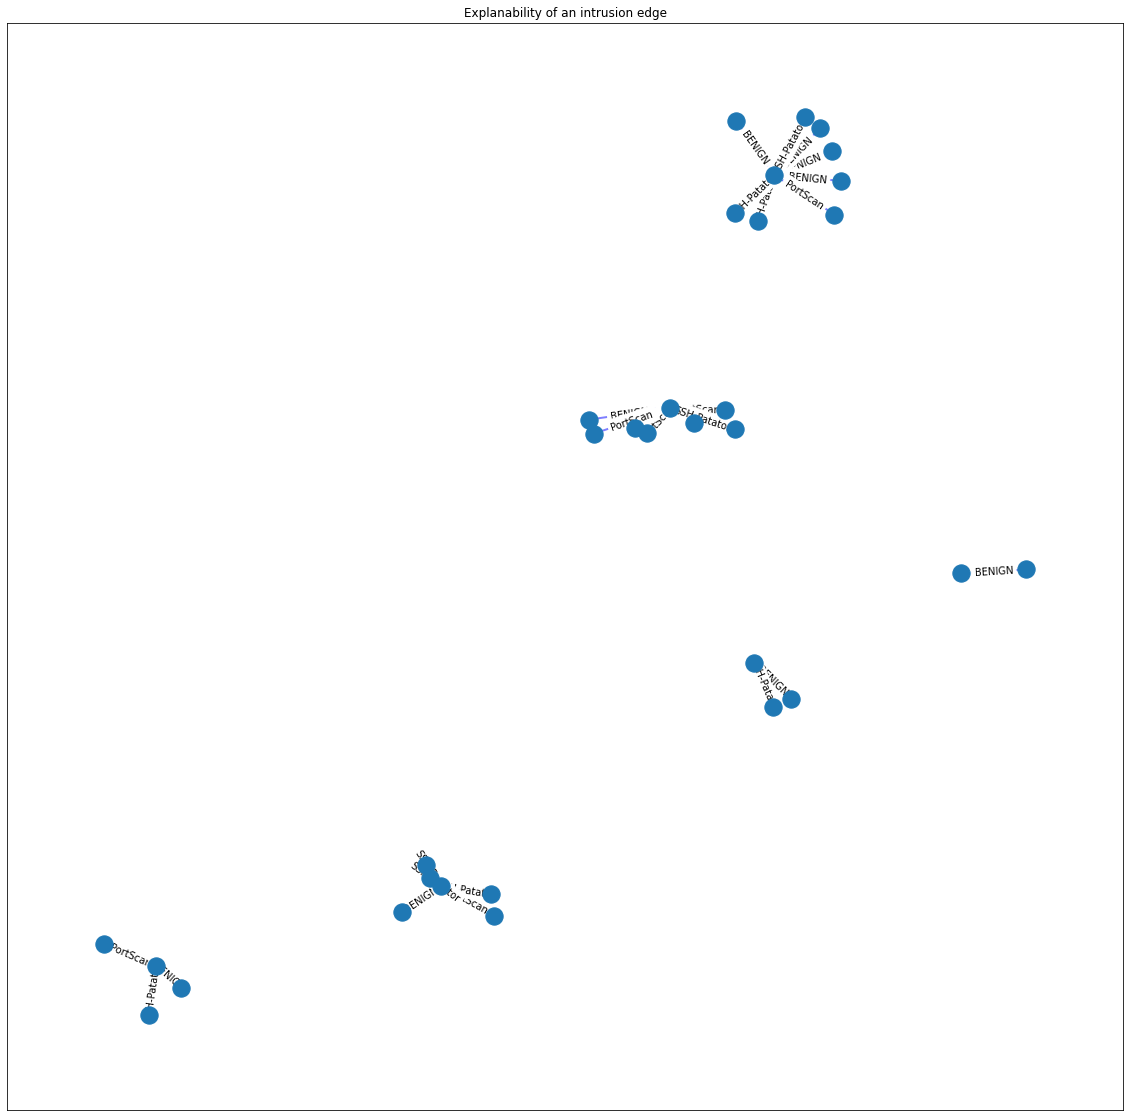

In [64]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[20,20])
plt.title("Explanability of an intrusion edge")
# pos = nx.planar_layout(nx_graph_intrusion)
pos = nx.spring_layout(nx_graph_intrusion, seed=3113794652)

nx.draw_networkx_edges(nx_graph_intrusion, pos, edgelist = edge_list, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(nx_graph_intrusion, pos, nodelist = nodes_list)
# nx.draw_networkx_labels(nx_graph_intrusion, pos, labels=None, nodelist = nodes_list)

nx.draw_networkx_edges(
    nx_graph_intrusion,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labels_11)

### Old implementation

In [209]:
edge_mask_intrusion_round = th.round(edge_mask_1)
edge_mask_benign_round = th.round(edge_mask_0)

import dgl
import matplotlib.pyplot as plt

nx_graph_0 = dgl.to_networkx(sub_graph_0.cpu())
nx_graph_1 = dgl.to_networkx(sub_graph_1.cpu())

{0: Text(0.6128301114846149, -0.1544954033953938, '0'),
 1: Text(-0.30156643619063445, -0.0186450104294781, '1'),
 2: Text(-0.5012209610680085, -0.8774518836885845, '2'),
 3: Text(-0.5701671888200804, 0.8470938102521856, '3'),
 4: Text(-0.6887437559565397, 0.733269328835652, '4'),
 5: Text(0.12641995255683014, -0.1253755329357395, '5'),
 6: Text(0.7596754120646761, -0.47252846043411956, '6'),
 7: Text(0.020517932381965247, 0.9573434392127644, '7'),
 8: Text(0.7015835653826024, -0.7549307444950348, '8'),
 9: Text(0.9938043299105648, -0.18855258943196254, '9'),
 10: Text(0.8630285278690071, -0.5488702486159778, '10'),
 11: Text(-0.8958315157548359, -0.49658663337143555, '11'),
 12: Text(-0.886788050295403, 0.3914834536340187, '12'),
 13: Text(0.16352992395342794, -0.9185098545478471, '13'),
 14: Text(-0.46265260933337565, 0.8599544457445764, '14'),
 15: Text(0.7429076944720767, 0.5632654560423341, '15'),
 16: Text(-0.7574015008303243, -0.6771151145604051, '16'),
 17: Text(-0.765754917180

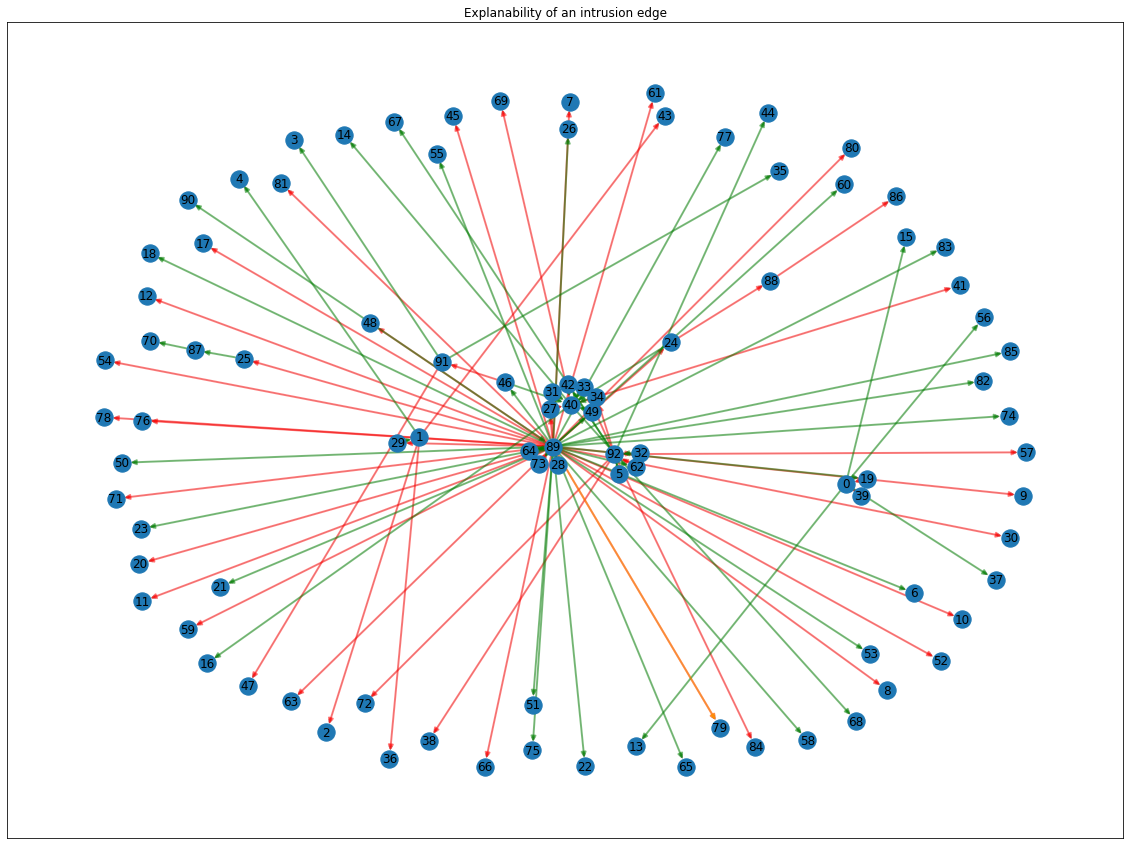

In [226]:
important_edges = []
not_important_edges = []

for i, x in enumerate(edge_mask_intrusion_round):
    if int(x.item()) == 0:
        not_important_edges.append(list(nx_graph_1.edges())[i])
    elif int(x.item()) == 1:
        important_edges.append(list(nx_graph_1.edges())[i])

        
pos = nx.spring_layout(nx_graph_1, seed=3113794652)  # positions for all nodes

plt.figure(figsize=[20,15])
plt.title("Explanability of an intrusion edge")
nx.draw_networkx_edges(nx_graph_1, pos, width = 0.5, alpha = 0.2)
nx.draw_networkx_edges(
    nx_graph_1,
    pos,
    edgelist = important_edges,
    width = 2,
    alpha = 0.5,
    edge_color = "red",
)
nx.draw_networkx_edges(
    nx_graph_1,
    pos,
    edgelist = not_important_edges,
    width = 2,
    alpha = 0.5,
    edge_color = "green",
)
nx.draw_networkx_edges(
    nx_graph_1,
    pos,
    edgelist = [list(nx_graph_1.edges())[edge_indice_1]],
    width = 2,
    alpha = 0.5,
    edge_color = "orange",
)


nx.draw_networkx_nodes(nx_graph_1, pos)
nx.draw_networkx_labels(nx_graph_1, pos)

{0: Text(-0.11967468838529904, 1.0, '0'),
 1: Text(-0.035801453655371955, -0.003011707200521525, '1'),
 2: Text(0.12650742308460525, -0.12507227145579186, '2'),
 3: Text(-0.09041282056613885, 0.20196401690520796, '3'),
 4: Text(-0.7057680679044459, 0.7431512460352302, '4'),
 5: Text(-0.41535066883871974, -0.8041076716136643, '5'),
 6: Text(0.5686458077318556, -0.688832935835787, '6'),
 7: Text(-0.2310854867989279, 0.9507774248074234, '7'),
 8: Text(0.7586672595340475, -0.6477625319432726, '8'),
 9: Text(0.9737524536506731, -0.16110109451460364, '9'),
 10: Text(-0.07857002393470078, -0.027892399255142582, '10'),
 11: Text(-0.9674263757561378, -0.3063930552960657, '11'),
 12: Text(0.1875248727925131, 0.23417191851987806, '12'),
 13: Text(0.37033557837489833, -0.8174802205550923, '13'),
 14: Text(-0.5328046872537763, 0.8422824890052115, '14'),
 15: Text(0.7895251451092935, 0.48711027994425043, '15'),
 16: Text(-0.8247958479368913, -0.5690772595826881, '16'),
 17: Text(-0.8150544078095467,

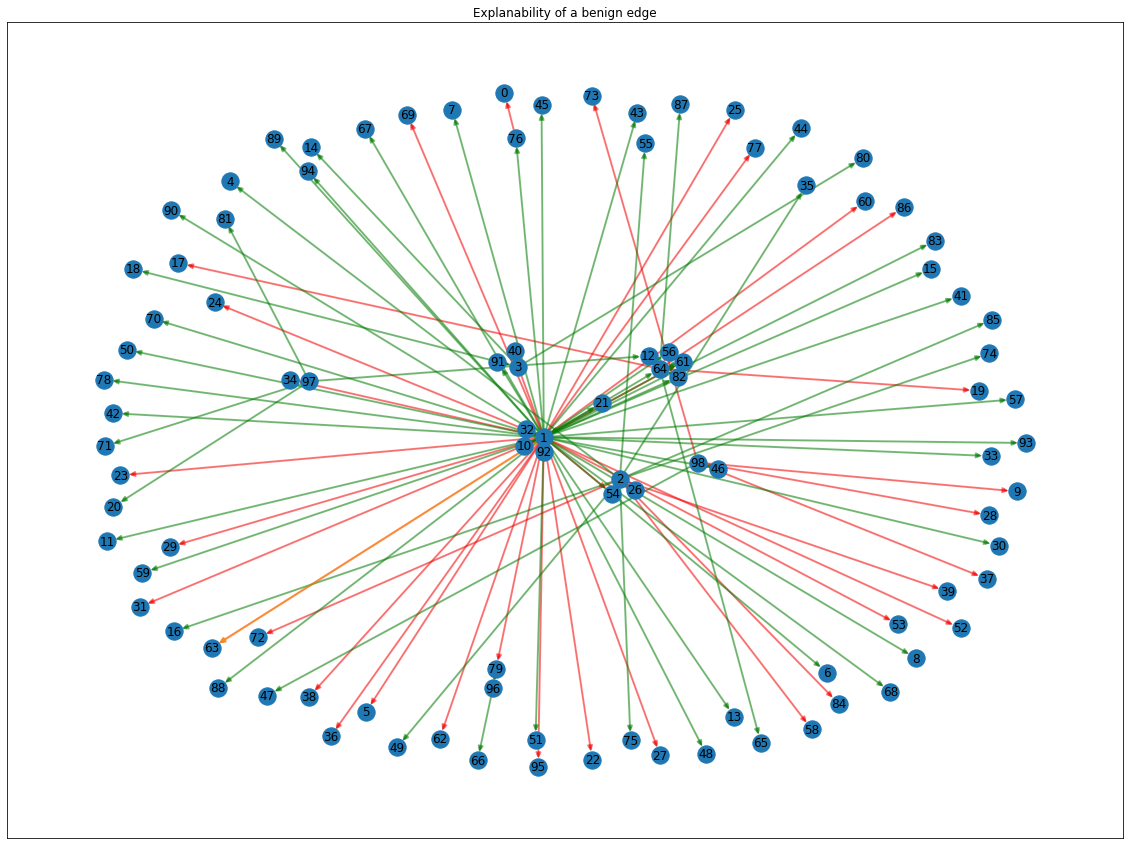

In [227]:
important_edges = []
not_important_edges = []

for i, x in enumerate(edge_mask_benign_round):
    if int(x.item()) == 0:
        not_important_edges.append(list(nx_graph_0.edges())[i])
    elif int(x.item()) == 1:
        important_edges.append(list(nx_graph_0.edges())[i])

        
pos = nx.spring_layout(nx_graph_0, seed=3113794652)  # positions for all nodes

plt.figure(figsize=[20,15])
plt.title("Explanability of a benign edge")
nx.draw_networkx_edges(nx_graph_0, pos, width = 0.5, alpha = 0.2)
nx.draw_networkx_edges(
    nx_graph_0,
    pos,
    edgelist = important_edges,
    width = 2,
    alpha = 0.5,
    edge_color = "red",
)
nx.draw_networkx_edges(
    nx_graph_0,
    pos,
    edgelist = not_important_edges,
    width = 2,
    alpha = 0.5,
    edge_color = "green",
)
nx.draw_networkx_edges(
    nx_graph_0,
    pos,
    edgelist = [list(nx_graph_0.edges())[edge_indice_0]],
    width = 2,
    alpha = 0.5,
    edge_color = "orange",
)


nx.draw_networkx_nodes(nx_graph_0, pos)
nx.draw_networkx_labels(nx_graph_0, pos)